ref. 
http://uspex.stonybrook.edu/pdfs/FingerprintSpaceParadigm-ActaCrystA-2010.pdf

# F-fingerprint
$$
F_{AB}(x) = \sum_{A_i} \sum_{B_j} \frac{\delta(R-R_{ij}) }{4 \pi R_{ij}^2 (N_A N_B / V_{uc}) \Delta } -1
$$




where
i
runs over all
$N_A$
atoms of type
A
within the unit cell
and
j
runs over all
$N_B$
atoms of type
B
in the extended unit cell,
$R_{ij}$
is the distance between these atoms,
$V_{uc}$
is the unit-cell
volume and

$\delta$
is the Dirac distribution. Each peak is smoothed
before calculating the sum using a Gaussian kernel $\sigma$ with

set
by the user (usually 0.02 A
 ̊
) and accumulated into a histogram
with bin size $\Delta$

(usually 0.05 A
 ̊
). Note that each
$F_{AB}$
starts with
the value of

-1 (at
R
= 0) and converges to zero.

## 上の定義はおかしいので修正して用いる。

$$
F_{AB}(x) = \sum_{A_i} \sum_{B_j} \frac{\delta(R-R_{ij}) }{4 \pi R_{ij}^2 (N_A N_B / V_{uc}) \Delta } -1
$$
$N_A,N_B$はunit cellのspecie A, Bの原子数。broadeningは行わずhistgramに入れる。

In [1]:
__author__ = "Hiori Kino"
__version__ = "1.0"
__date__ = "Sep. 23, 2017"

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp

if False:
    def gaussian_broadening( xi, xc,sigma=0.05):

        xc = np.array(xc)
        y = np.exp( -0.5*( (xi[:,None]-xc[None,:])/sigma )**2 )/(np.sqrt(np.pi*2.0)*sigma)/ xc[None,:]**2

        y0 = np.sum(y,axis=1)
        return y0



In [3]:
from pymatgen import Lattice, Structure, Molecule
import collections
import itertools
import numpy as np
from pymatgen.core.periodic_table import Element




class f_fingerprint:
    """
    calculate f-fingerprint function used in USPEX.
    """
    @staticmethod
    def calc_Natom(structure):
        """ 
        calculate sum of specie
        @param  structure : pymatgen structure
        @return : collections.Counter
        """
        site = []
        for st in structure:
            site.append(st.specie)
        Natom = collections.Counter(site)
        return Natom  
    
    @staticmethod
    def uniq_atoms_order(Natom):
        """
        calculate unique atom list and order the list by Z
        
        @param Natom : return value of calc_Natom
        @return : ordered unique atom list
        """
        uniq_atoms = [ x for x in Natom.keys() ]
        uniq_atoms = set(uniq_atoms)
        y = []
        uniq_atoms = list(uniq_atoms)

        for x in uniq_atoms:
            y.append( Element(x).Z )
        y = np.array(y)
        iy = np.argsort(y)
        ua = []
        for i in iy:
            ua.append( uniq_atoms[i])
        return ua
    
    @staticmethod
    def my_hist(xi,xc):
        """
        calculate histgram of xc , bin = xi
        
        @param xi: boundary of bins
        @param xc: a list of values
        @return : hist of xc
        """
        xc = np.array(xc)
        xc2 = 1.0/ xc**2
        h = xi[1]-xi[0]
        n = len(xi)-1
        ixc = list(map(int,(xc - xi[0] )/h))
        y = np.zeros( n )
        for i,w in zip(ixc,xc2):
            if 0<=i and i<n:
                y[i] += w
            else:
                print ("warning",i)
                for j,x in zip(ixc,xc):
                    if j<=0:
                        print(j,x)

        return y
        
    def __init__(self,structure):
        """
        @param structure : pymatgen.structure
        """
        self.structure = structure
    
    def estimate_rmin(self,rmax=4):

        rminlist = []

        for st  in structure:
            neighbors = structure.get_neighbors(st,rmax)
            for x in neighbors:
                rminlist.append(x[1])
        return np.array(rminlist).min()
        
    def evaluate(self,    rmin,rmax,npoints):
        """
        ylist : fingerprint function, 2D list
        
        @param rmin : min value of r
        @param rmax : max value of r
        @param npoints : number of bins between rmin and rmax
        """
        self.rmin = rmin
        self.rmax = rmax
        self.npoints = npoints



        Natom = self.calc_Natom(structure)
        uniq_atoms = self.uniq_atoms_order(Natom)

        self.uniq_atoms = uniq_atoms


        xi = np.linspace(rmin,rmax,npoints+1)

        Delta = xi[1]-xi[0]
        ximid=[]
        for x1,x2 in zip( xi[:-1], xi[1:]):
            ximid.append( (x1+x2)*0.5 )
        """
        ximid[] = mid points of xi[]
        """

        comblist = list(itertools.combinations_with_replacement(uniq_atoms,2))
        self.comblist = comblist
        """
        comblist = combination list of uniq atoms
        """

        
        yall = []
        for comb in comblist:
            na = 0
            nb = 0
            y = np.zeros( (npoints) )
            for st  in structure:
                if st.specie == comb[0]:
                    na += 1
                    neighbors = structure.get_neighbors(st,rmax)
                    if neighbors[0][1] < rmin:
                        print("rdf.min=",neighbors[0][1] )
                    length = []
                    for x in neighbors:
                        if x[0].specie == comb[1]:
                            length.append(x[1])
 

                    length = np.array(length)

                    y1 = self.my_hist(xi,length)

                    y += y1/ Natom[comb[1]]


            y = y * structure.volume/ (4.0 * np.pi * na * Delta ) -1



            yall.append(list(y))

        self.xi = xi
        self.ximid = ximid
        self.ylist = yall
        """
        self.ylist = fingerprint functions, len(self.ylist) = npoints * len(comblist)
        """
        return self.xi,self.ximid,self.ylist
    
    def plot(self):
        """
        plot fignerprint function
        """
        print(self.comblist)
        print(self.npoints*len(self.comblist))

        y = []
        for x in self.ylist:
            y.extend(x)
        plt.plot(y)
        plt.show()



Full Formula (Ho1 Cd1)
Reduced Formula: HoCd
abc   :   3.735261   3.735261   3.735261
angles:  90.000000  90.000000  90.000000
Sites (2)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Ho    0.5  0.5  0.5
  1  Cd    0    0    0
rmin= 3.23483091577
[(Element Cd, Element Cd), (Element Cd, Element Ho), (Element Ho, Element Ho)]
150


Full Formula (Er6 Zn30)
Reduced Formula: ErZn5
abc   :   8.876136   8.876137   9.033519
angles:  90.000000  90.000000 119.999998
Sites (36)
  #  SP           a         b         c
---  ----  --------  --------  --------
  0  Er    0.189448  0.378896  0.25
  1  Er    0.810552  0.189448  0.75
  2  Er    0.378896  0.189448  0.75
  3  Er    0.621104  0.810552  0.25
  4  Er    0.189448  0.810552  0.25
  5  Er    0.810552  0.621104  0.75
  6  Zn    0         0         0
  7  Zn    0         0         0.5
  8  Zn    0.333333  0.666667  0.019295
  9  Zn    0.666667  0.333333  0.519295
 10  Zn    0.666667  0.333333  0.980705
 11  Zn    0.333333  0.666667  0.480705
 12  Zn    0.5       0         0
 13  Zn    0.5       0.5       0.5
 14  Zn    0         0.5       0.5
 15  Zn    0         0.5       0
 16  Zn    0.5       0.5       0
 17  Zn    0.5       0         0.5
 18  Zn    0.567716  0.135431  0.25
 19  Zn    0.432284  0.567716  0.75
 20  Zn    0.135431  0.567716  0.75
 21  Zn    0.864569  0.4

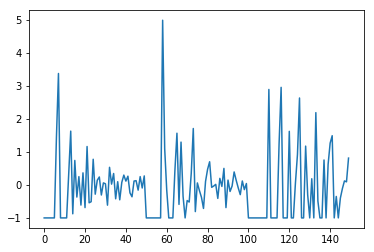

Full Formula (Nd8 Fe56 B4)
Reduced Formula: Nd2Fe14B
abc   :   8.795000   8.795000  12.188000
angles:  90.000000  90.000000  90.000000
Sites (68)
  #  SP         a       b       c
---  ----  ------  ------  ------
  0  Nd    0.2313  0.7687  0
  1  Nd    0.7687  0.2313  0
  2  Nd    0.7313  0.7313  0.5
  3  Nd    0.2687  0.2687  0.5
  4  Nd    0.3585  0.3585  0
  5  Nd    0.6415  0.6415  0
  6  Nd    0.1415  0.8585  0.5
  7  Nd    0.8585  0.1415  0.5
  8  Fe    0.0379  0.3587  0.3237
  9  Fe    0.9621  0.6413  0.3237
 10  Fe    0.1413  0.5379  0.8237
 11  Fe    0.8587  0.4621  0.8237
 12  Fe    0.4621  0.8587  0.1763
 13  Fe    0.5379  0.1413  0.1763
 14  Fe    0.3587  0.0379  0.6763
 15  Fe    0.6413  0.9621  0.6763
 16  Fe    0.9621  0.6413  0.6763
 17  Fe    0.0379  0.3587  0.6763
 18  Fe    0.8587  0.4621  0.1763
 19  Fe    0.1413  0.5379  0.1763
 20  Fe    0.5379  0.1413  0.8237
 21  Fe    0.4621  0.8587  0.8237
 22  Fe    0.6413  0.9621  0.3237
 23  Fe    0.3587  0.0379  0.3237
 2

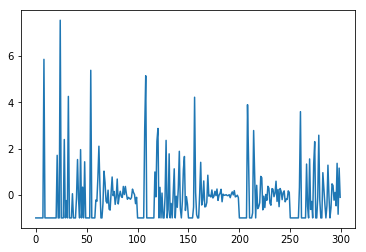

Full Formula (B3 N3)
Reduced Formula: BN
abc   :   2.504000   2.504000  10.000000
angles:  90.000000  90.000000 120.000000
Sites (6)
  #  SP           a         b         c
---  ----  --------  --------  --------
  0  B     0         0         0
  1  B     0.666667  0.333333  0.333333
  2  B     0.333333  0.666667  0.666667
  3  N     0         0         0.33333
  4  N     0.666667  0.333333  0.666663
  5  N     0.333333  0.666667  0.999997
rmin= 1.44568507444
[(Element B, Element B), (Element B, Element N), (Element N, Element N)]
150


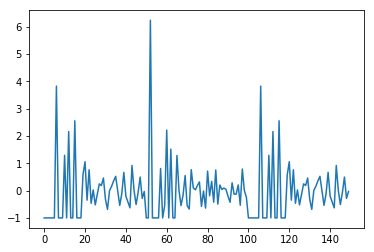

Full Formula (H12 C4 O12)
Reduced Formula: H3CO3
abc   :   6.119000   3.607000  11.889100
angles:  90.000000 103.280000  90.000000
Sites (28)
  #  SP         a       b       c
---  ----  ------  ------  ------
  0  H     0.173   0.9953  0.2087
  1  H     0.827   0.4953  0.2913
  2  H     0.827   0.0047  0.7913
  3  H     0.173   0.5047  0.7087
  4  H     0.3207  0.1587  0.3795
  5  H     0.6793  0.6587  0.1205
  6  H     0.6793  0.8413  0.6205
  7  H     0.3207  0.3413  0.8795
  8  H     0.5453  0.4508  0.1584
  9  H     0.4547  0.9508  0.3416
 10  H     0.4547  0.5492  0.8416
 11  H     0.5453  0.0492  0.6584
 12  C     0.0965  0.0548  0.0511
 13  C     0.9035  0.5548  0.4489
 14  C     0.9035  0.9452  0.9489
 15  C     0.0965  0.4452  0.5511
 16  O     0.0633  0.56    0.6481
 17  O     0.9367  0.06    0.8519
 18  O     0.9367  0.44    0.3519
 19  O     0.0633  0.94    0.1481
 20  O     0.2562  0.2305  0.0361
 21  O     0.7438  0.7305  0.4639
 22  O     0.7438  0.7695  0.9639
 23  O  

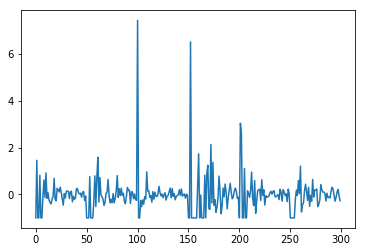

In [4]:
if __name__ == "__main__":
    filelist = [ "POSCAR.mp-170_HoCd", "POSCAR.mp-225_ErZn5", 
    "Nd2Fe17B-4295279230-1-2.cif", "BN-4296219629-1-2.cif" ,"C2H6O6-4296368890-1-2.cif"]
    #filelist = [ "C2H6O6-4296368890-1-2.cif"]
    #filelist = ["Nd2Fe17B-4295279230-1-2.cif" ]
    for file_ in filelist: 
        structure = Structure.from_file(file_)
        print(structure)        
        npoints = 50
        rmin = 0.7
        rmax = 15
        ff = f_fingerprint(structure)
        est_rmin = ff.estimate_rmin()
        print("rmin=",est_rmin)
        ff.evaluate(rmin,rmax,npoints)
        ff.plot()